In [8]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [9]:
import pandas as pd
from autogluon.tabular import TabularPredictor

### Data

datetime - hourly date + timestamp
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter
holiday - whether the day is considered a holiday
workingday - whether the day is neither a weekend nor holiday
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
temp - temperature in Celsius
atemp - "feels like" temperature in Celsius
humidity - relative humidity
windspeed - wind speed
casual - number of non-registered user rentals initiated
registered - number of registered user rentals initiated
count - number of total rentals

In [10]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("./Data/train.csv")
train['datetime'] = pd.to_datetime(train['datetime'])
train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>],
       [<AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>]], dtype=object)

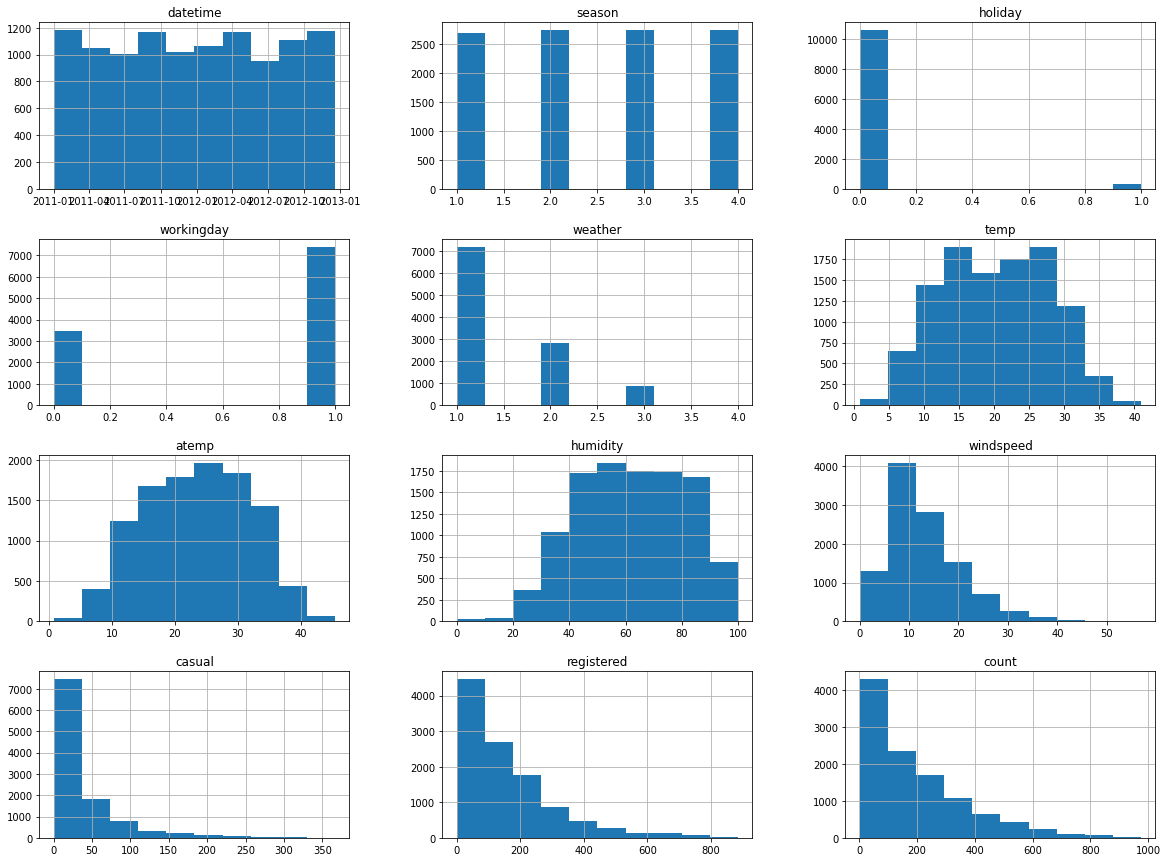

In [11]:
# Histogram to show all the data distributions including the target
%matplotlib inline

train.hist(figsize=(20, 15))

In [12]:
# Investigate to see if any data are correlated positively or negatively
train.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


In [13]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [14]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("./Data/test.csv")
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [15]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


In [16]:
# Same thing as train and test dataset
submission = pd.read_csv("./Data/sampleSubmission.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [17]:
submission.describe()

,count
count,6493.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


### Model

Requirements:
- We are predicting count, so it is the label we are setting.
- Ignore casual and registered columns as they are also not present in the test dataset.
- Use the root_mean_squared_error as the metric to use for evaluation.
- Set a time limit of 10 minutes (600 seconds).
- Use the preset best_quality to focus on creating the best model.

In [18]:
learner_kwargs = {
    'ignored_columns': ['casual', 'registered']
}

In [72]:
predictor = TabularPredictor(label="count", problem_type="regression", eval_metric="root_mean_squared_error", learner_kwargs=learner_kwargs).fit(
    train_data = train,
    time_limit = 600,
    presets = "best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220718_213655\"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220718_213655\"
AutoGluon Version:  0.5.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2137.93 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fittin

In [76]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -50.428314      25.042783  425.511158                0.000554           1.145018            3       True         18
1   NeuralNetFastAI_BAG_L2  -51.575689      23.381067  408.094586                1.104650          53.252690            2       True         16
2   RandomForestMSE_BAG_L2  -53.192385      23.210769  365.772005                0.934352          10.930110            2       True         13
3     ExtraTreesMSE_BAG_L2  -53.639684      23.003228  360.183340                0.726810           5.341444            2       True         15
4          LightGBM_BAG_L2  -54.730151      22.635210  360.856817                0.358792           6.014921            2       True         12
5           XGBoost_BAG_L2  -55.278658      22.571365  366.612289         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_pe

In [77]:
predictions = predictor.predict(test)

In [78]:
predictions.head()

0    25.388779
1    41.943302
2    46.481602
3    48.296814
4    50.782539
Name: count, dtype: float32

In [79]:
predictions.describe()

count    6493.000000
mean       99.140678
std        88.224846
min         0.477703
25%        20.877464
50%        66.991837
75%       165.549103
max       351.056091
Name: count, dtype: float64

In [ ]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [82]:
submission.head(100)

,datetime,count
0,2011-01-20 00:00:00,25.388779
1,2011-01-20 01:00:00,41.943302
2,2011-01-20 02:00:00,46.481602
3,2011-01-20 03:00:00,48.296814
4,2011-01-20 04:00:00,50.782539
...,...,...
95,2011-01-24 01:00:00,71.526871
96,2011-01-24 03:00:00,71.932152
97,2011-01-24 04:00:00,60.287888
98,2011-01-24 05:00:00,60.292976


In [84]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission attempt: 3"

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/195k [00:00<?, ?B/s]
100%|##########| 195k/195k [00:00<00:00, 280kB/s]


## Obtained first raw score of 1.80763

# Feature Engineering

In [19]:
# First, normalize the features temperature, relative temperature, humidity, and windspeed
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler = MinMaxScaler()
# transform data (training)
temp = train['temp'].values.reshape(-1, 1)
atemp = train['atemp'].values.reshape(-1, 1)
humidity = train['humidity'].values.reshape(-1, 1)
windspeed = train['windspeed'].values.reshape(-1, 1)
train['temp'] = scaler.fit_transform(temp)
train['atemp'] = scaler.fit_transform(atemp)
train['humidity'] = scaler.fit_transform(humidity)
train['windspeed'] = scaler.fit_transform(windspeed)

In [21]:
# transform test data too for later
tempt = test['temp'].values.reshape(-1, 1)
atempt = test['atemp'].values.reshape(-1, 1)
humidityt = test['humidity'].values.reshape(-1, 1)
windspeedt = test['windspeed'].values.reshape(-1, 1)
test['temp'] = scaler.fit_transform(tempt)
test['atemp'] = scaler.fit_transform(atempt)
test['humidity'] = scaler.fit_transform(humidityt)
test['windspeed'] = scaler.fit_transform(windspeedt)

In [101]:
predictor_normalized = TabularPredictor(label="count", problem_type="regression", eval_metric="root_mean_squared_error", learner_kwargs=learner_kwargs).fit(
    train_data = train,
    time_limit = 100,
    presets = "best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220718_220011\"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 100s
AutoGluon will save models to "AutogluonModels/ag-20220718_220011\"
AutoGluon Version:  0.5.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3443.59 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fittin

In [102]:
predictor_normalized.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                    model   score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L3  -54.613405      21.824050  66.442641                0.000000           0.168001            3       True         10
1         LightGBM_BAG_L2  -54.624243      17.967371  52.900547                0.250231           5.640877            2       True          9
2       LightGBMXT_BAG_L2  -60.912757      21.573819  60.633763                3.856679          13.374093            2       True          8
3     WeightedEnsemble_L2  -84.146423       0.033482   0.539645                0.000000           0.466699            2       True          7
4   KNeighborsDist_BAG_L1  -84.146423       0.033482   0.072946                0.033482           0.072946            1       True          2
5   KNeighborsUnif_BAG_L1 -101.588176       0.030992   0.094839                0.03099

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.58817625927213,
  'KNeighborsDist_BAG_L1': -84.14642264302962,
  'LightGBMXT_BAG_L1': -131.376690801181,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.53587644360984,
  'CatBoost_BAG_L1': -137.27000137760038,
  'WeightedEnsemble_L2': -84.14642264302962,
  'LightGBMXT_BAG_L2': -60.912757320283724,
  'LightGBM_BAG_L2': -54.62424319028297,
  'WeightedEnsemble_L3': -54.61340544288559},


In [104]:
predictions_normalized = predictor_normalized.predict(test)

In [137]:
predictions_normalized.head()

0    32.821739
1    42.544937
2    46.057392
3    49.508232
4    50.222870
Name: count, dtype: float32

In [108]:
predictions_normalized.describe()

count    6493.000000
mean      100.295258
std        89.984291
min        -6.651858
25%        17.808601
50%        63.910889
75%       170.488876
max       369.346191
Name: count, dtype: float64

In [114]:
predictions_normalized[predictions_normalized < 0]

5631   -6.651858
Name: count, dtype: float32

In [143]:
predictions_normalized_n = pd.DataFrame(predictions_normalized)
predictions_normalized = predictions_normalized_n.clip(lower=0)

In [144]:
submission["count"] = predictions_normalized
submission.to_csv("submission_normalized.csv", index=False)

In [145]:
!kaggle competitions submit -c bike-sharing-demand -f submission_normalized.csv -m "try normalized features"

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/195k [00:00<?, ?B/s]
 94%|#########4| 184k/195k [00:00<00:00, 1.87MB/s]
100%|##########| 195k/195k [00:00<00:00, 247kB/s] 


## New score (with normalized features): 1.79863

In [146]:
# Now lets seperate date/month/time column

In [22]:
train['year'] = pd.DatetimeIndex(train['datetime']).year
train['month'] = pd.DatetimeIndex(train['datetime']).month
train['day'] = pd.DatetimeIndex(train['datetime']).day
train['hour'] = pd.DatetimeIndex(train['datetime']).hour

test['year'] = pd.DatetimeIndex(test['datetime']).year
test['month'] = pd.DatetimeIndex(test['datetime']).month
test['day'] = pd.DatetimeIndex(test['datetime']).day
test['hour'] = pd.DatetimeIndex(test['datetime']).hour

In [23]:
# turn into categories
train["season"] = train.season.astype('category')
train["weather"] = train.weather.astype('category')
test["season"] = test.season.astype('category')
test["weather"] = test.season.astype('category')

In [24]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,0.224490,0.305068,0.81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,0.204082,0.288064,0.80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,0.204082,0.288064,0.80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,0.224490,0.305068,0.75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,0.224490,0.305068,0.75,0.0,0,1,1,2011,1,1,4


In [25]:
learner_kwargs_new = {
    'ignored_columns': ['casual', 'registered', 'datetime']
}

In [169]:
predictor_new_features = TabularPredictor(label="count", problem_type="regression", eval_metric="root_mean_squared_error", learner_kwargs=learner_kwargs_new).fit(
    train_data = train,
    time_limit = 600,
    presets = "best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220719_212944\"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220719_212944\"
AutoGluon Version:  0.5.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered', 'datetime']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2599.6 MB
	Train Data (Original)  Memory Usage: 0.89 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generato

In [170]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -35.327567      31.525754  534.061895                0.000000           0.223697            3       True         18
1   NeuralNetFastAI_BAG_L2  -35.769716      30.194975  388.239176                0.389047          24.398873            2       True         17
2          CatBoost_BAG_L2  -35.897898      29.983325  495.353565                0.177397         131.513262            2       True         15
3     ExtraTreesMSE_BAG_L2  -35.914085      30.291250  366.074793                0.485322           2.234490            2       True         16
4          LightGBM_BAG_L2  -35.979121      29.956012  368.337570                0.150084           4.497268            2       True         13
5      WeightedEnsemble_L2  -36.010718      27.488872  314.132912         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsemb

In [184]:
predictor_new_features.feature_importance(data=train)

Computing feature importance via permutation shuffling for 12 features using 5000 rows with 5 shuffle sets...
	1187.54s	= Expected runtime (237.51s per shuffle set)
	1284.63s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
hour,193.668801,1.577970,5.288095e-10,5,196.917863,190.419738
workingday,84.778143,2.770675,1.367004e-07,5,90.483001,79.073284
year,63.676955,1.002541,7.370847e-09,5,65.741201,61.612709
month,28.900114,0.541100,1.473971e-08,5,30.014246,27.785982
humidity,26.376269,0.905970,1.667634e-07,5,28.241675,24.510864
temp,22.825404,0.609219,6.083978e-08,5,24.079794,21.571014
weather,13.688126,0.836918,1.668686e-06,5,15.411352,11.964901
atemp,13.082118,0.614873,5.838907e-07,5,14.348149,11.816087
day,10.410867,0.390411,2.368691e-07,5,11.214729,9.607005
season,8.408513,0.217429,5.360260e-08,5,8.856202,7.960824


In [171]:
predictions_new_features = predictor_new_features.predict(test)

In [172]:
predictions_new_features.head()

0    12.982582
1     6.399722
2     4.766326
3     3.452071
4     3.687432
Name: count, dtype: float32

In [173]:
predictions_new_features.describe()

count    6493.000000
mean      178.012970
std       161.528534
min        -1.681530
25%        45.272964
50%       140.856476
75%       264.509888
max       864.865356
Name: count, dtype: float64

In [177]:
predictions_new_features[predictions_new_features < 0].size

6

In [178]:
predictions_new_features = predictions_new_features.clip(lower=0)

In [179]:
submission["count"] = predictions_new_features
submission.to_csv("submission_new_features.csv", index=False)

In [181]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "added new features (2)"

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/194k [00:00<?, ?B/s]
  4%|4         | 8.00k/194k [00:01<00:25, 7.56kB/s]
 41%|####1     | 80.0k/194k [00:01<00:01, 67.1kB/s]
 49%|####9     | 96.0k/194k [00:01<00:01, 55.3kB/s]
 58%|#####7    | 112k/194k [00:03<00:02, 30.6kB/s] 
 74%|#######4  | 144k/194k [00:03<00:01, 38.6kB/s]
 82%|########2 | 160k/194k [00:06<00:01, 19.7kB/s]
 90%|######### | 176k/194k [00:06<00:00, 21.5kB/s]
 95%|#########4| 184k/194k [00:07<00:00, 20.3kB/s]
 99%|#########8| 192k/194k [00:08<00:00, 16.3kB/s]
100%|##########| 194k/194k [00:08<00:00, 14.8kB/s]
100%|##########| 194k/194k [00:11<00:00, 17.4kB/s]


## new score: 0.50277!

# Hyperparameter Optimization

In [3]:
# Autogluon only comes with random search, but now we will play with the parameters

In [4]:
# First, play with higher level hyperparameters

In [47]:
hyperparameter_tune_kwargs = {
    'num_trials' : 5,
    'searcher' : 'auto'
}

In [48]:
predictor_hpo_tune = TabularPredictor(label="count", problem_type="regression", eval_metric="root_mean_squared_error", learner_kwargs=learner_kwargs_new).fit(
    train_data = train,
    time_limit = 600,
    presets = "best_quality",
    num_stack_levels = 3, # set stacking, bagging to highest levels
    num_bag_folds = 10,
    auto_stack = False
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220725_214737\"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220725_214737\"
AutoGluon Version:  0.5.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    10886
Train Data Columns: 15
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered', 'datetime']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5928.62 MB
	Train Data (Original)  Memory Usage: 0.89 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generat

In [49]:
predictor_hpo_tune.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -35.102103      29.084932  335.933551                0.001497           0.536280            3       True         16
1   NeuralNetFastAI_BAG_L2  -35.488157      27.001436  222.892599                0.615378          40.266329            2       True         15
2      WeightedEnsemble_L4  -35.544452      31.194001  437.341902                0.000000           0.340467            4       True         23
3          CatBoost_BAG_L3  -35.636764      29.174720  388.059837                0.091285          52.662566            3       True         20
4          CatBoost_BAG_L2  -35.711171      26.472473  266.404090                0.086415          83.777820            2       True         13
5          LightGBM_BAG_L2  -35.752457      26.558913  192.075283         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L3': 'StackerEnsembleModel_LGB',
  'RandomForest

In [161]:
predictions_hpo_tune = predictor_hpo_tune.predict(test)


KeyboardInterrupt



In [51]:
predictions_hpo_tune.head()

0    14.031633
1     4.218542
2     2.839131
3     3.180840
4     3.024372
Name: count, dtype: float32

In [52]:
predictions_hpo_tune.describe()

count    6493.000000
mean      178.917221
std       161.929672
min        -1.292561
25%        45.639431
50%       141.956512
75%       262.864410
max       850.173950
Name: count, dtype: float64

In [53]:
predictions_hpo_tune = predictions_hpo_tune.clip(lower=0)

In [54]:
submission["count"] = predictions_hpo_tune
submission.to_csv("submission_hpo_tune.csv", index=False)

In [55]:
!kaggle competitions submit -c bike-sharing-demand -f submission_hpo_tune.csv -m "hpo tuning"

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/194k [00:00<?, ?B/s]
  4%|4         | 8.00k/194k [00:00<00:02, 64.9kB/s]
100%|##########| 194k/194k [00:01<00:00, 189kB/s]  


In [162]:
predictor_hpo_tune_2 = TabularPredictor(label="count", problem_type="regression", eval_metric="root_mean_squared_error", learner_kwargs=learner_kwargs_new).fit(
    train_data = train,
    time_limit = 600,
    presets = "best_quality",
    num_stack_levels = 2, # set stacking, bagging to highest levels
    num_bag_folds = 5,
    auto_stack = False
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220725_233347\"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220725_233347\"
AutoGluon Version:  0.5.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    10886
Train Data Columns: 15
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered', 'datetime']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    4997.82 MB
	Train Data (Original)  Memory Usage: 0.89 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generat

In [163]:
predictions_hpo_tune_2 = predictor_hpo_tune_2.predict(test)

In [164]:
predictions_hpo_tune_2.describe()
predictions_hpo_tune_2 = predictions_hpo_tune_2.clip(lower=0)

In [165]:
submission["count"] = predictions_hpo_tune_2
submission.to_csv("submission_hpo_tune_2.csv", index=False)

In [166]:
!kaggle competitions submit -c bike-sharing-demand -f submission_hpo_tune_2.csv -m "hpo tuning 2"

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/194k [00:00<?, ?B/s]
  4%|4         | 8.00k/194k [00:00<00:03, 57.6kB/s]
100%|##########| 194k/194k [00:00<00:00, 974kB/s]  
100%|##########| 194k/194k [00:00<00:00, 268kB/s]


## Score of 0.50987

In [125]:
# Try XGBoost

In [98]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE
import numpy as np

In [88]:
train_d = pd.read_csv("./Data/train.csv")
train_d['datetime'] = pd.to_datetime(train_d['datetime'])
train_d['year'] = pd.DatetimeIndex(train_d['datetime']).year
train_d['month'] = pd.DatetimeIndex(train_d['datetime']).month
train_d['day'] = pd.DatetimeIndex(train_d['datetime']).day
train_d['hour'] = pd.DatetimeIndex(train_d['datetime']).hour
columns = ['datetime', 'casual', 'registered']
train_d = train_d.drop(columns, axis=1)

In [143]:
X_train = train_d.loc[:, train_d.columns != "count"]
y_train = train_d['count']

In [92]:
test_d = pd.read_csv("./Data/test.csv")
test_d['datetime'] = pd.to_datetime(test_d['datetime'])
test_d['year'] = pd.DatetimeIndex(test_d['datetime']).year
test_d['month'] = pd.DatetimeIndex(test_d['datetime']).month
test_d['day'] = pd.DatetimeIndex(test_d['datetime']).day
test_d['hour'] = pd.DatetimeIndex(test_d['datetime']).hour
test_d = test_d.drop('datetime', axis=1)

In [93]:
dtrain = xgb.DMatrix(train_d.loc[:, train_d.columns != "count"], train_d['count'],  enable_categorical=True )
dtest = xgb.DMatrix(test_d.loc[:, test_d.columns != "count"], enable_categorical = True)

C:\Users\grace\anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [133]:
# How does the model perform on the training dataset and default model parameters?
# Using the hyperparameters in the requirements, is there improvement?
# Remember we use the test dataset to score the model
param = {
    "max_depth": 10,
    "eta": 0.03,
    "gamma": 0.09,
    "colsample_bytree": 0.5,
    "objective": "reg:squarederror",
    "eval_metric": "rmse"
}
num_round=1000
bst = xgb.train(param, dtrain, num_round)

In [134]:
prediction_xgb = bst.predict(dtest)

In [135]:
prediction_xgb = prediction_xgb.clip(min=0)

In [136]:
submission["count"] = prediction_xgb
submission.to_csv("submission_xgb.csv", index=False)

In [137]:
!kaggle competitions submit -c bike-sharing-demand -f submission_xgb.csv -m "xgb only"

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/194k [00:00<?, ?B/s]
  4%|4         | 8.00k/194k [00:00<00:03, 60.7kB/s]
100%|##########| 194k/194k [00:00<00:00, 1.01MB/s] 
100%|##########| 194k/194k [00:00<00:00, 265kB/s] 


## Score of 0.69663

In [126]:
# Try neural network

In [140]:
from sklearn.neural_network import MLPRegressor

In [145]:
regr = MLPRegressor(random_state=0, max_iter=500).fit(X_train, y_train)

In [147]:
predictions_mlp = regr.predict(test_d)

In [149]:
predictions_mlp = predictions_mlp.clip(min=0)

In [150]:
submission["count"] = predictions_mlp
submission.to_csv("submission_mlp.csv", index=False)

In [151]:
!kaggle competitions submit -c bike-sharing-demand -f submission_mlp.csv -m "mlp only"

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/246k [00:00<?, ?B/s]
  3%|3         | 8.00k/246k [00:00<00:04, 58.5kB/s]
 91%|######### | 224k/246k [00:00<00:00, 1.14MB/s] 
100%|##########| 246k/246k [00:03<00:00, 65.0kB/s]


## Score of 1.34434

# Summary

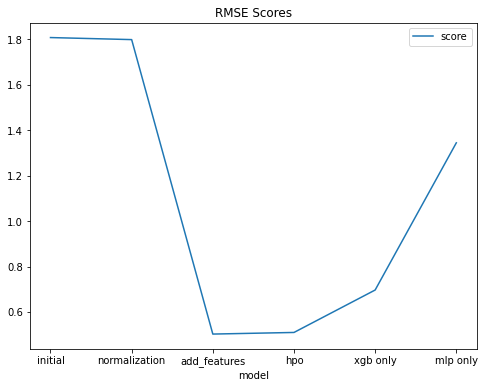

In [155]:
fig = pd.DataFrame(
    {
        "model": ["initial", "normalization", "add_features", "hpo 1", "hpo 2", "xgb only", "mlp only"],
        "score": [1.80763, 1.79863, 0.50277, 0.50987, ? , 0.69663 , 01.34434]
    }
).plot(x="model", y="score", title = "RMSE Scores", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

In [159]:
pd.DataFrame({
    "model": ["initial", "add_features", "hpo 1", "hpo 2"],
    "time": [600, 600, 600, 600],
    "num_bag_folds": [0, 0, 10, 5],
    "num_stack_levels": [0, 0, 3, 2],
    "score": [1.80763, 0.50277, 0.50987, ?]
})

,model,time,num_bag_folds,num_stack_levels,score
0,initial,600,0,0,1.80763
1,add_features,600,0,0,0.50277
2,hpo,600,10,3,0.50987
